In [1]:
# Install PyTorch if not already installed
%pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Simple Normalizing Flow without PyTorch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

print("Running PyTorch-free normalizing flow...")

# ---------- STEP 1: Simulate Markov Chain Samples ----------
'''def target_pdf(x):
    """Unnormalized Cauchy-like distribution"""
    return 1 / (1 + (x-1)**2)'''


# ----- Multimodal Target Distribution -----
def target_pdf(x):
    return 1 / (1 + (x - 2)**2) + 1 / (1 + (x + 2)**2)

def metropolis_sampler(f, N, x0=0.0, step_size=1.0):
    """Metropolis-Hastings sampler"""
    samples = [x0]
    x = x0
    accepted = 0
    
    for i in range(N):
        x_new = x + step_size * np.random.randn()
        alpha = min(1, f(x_new) / f(x))
        if np.random.rand() < alpha:
            x = x_new
            accepted += 1
        samples.append(x)
    
    print(f"MCMC acceptance rate: {accepted/N:.2%}")
    return np.array(samples)

# Generate MCMC samples
np.random.seed(42)
print("Generating MCMC samples...")
samples_np = metropolis_sampler(target_pdf, N=10000, step_size=1.0)               #import samples from MarkovChainSampleCreation.ipynb, as they will be cleaned.
print(f"Generated {len(samples_np)} samples")
print(f"Sample statistics: mean={np.mean(samples_np):.3f}, std={np.std(samples_np):.3f}")

# ---------- STEP 2: Simple Normalizing Flow Implementation ----------
class SimpleNormalizingFlow:
    """Simple 1D normalizing flow using polynomial transformations"""
    
    def __init__(self, n_layers=4):
        self.n_layers = n_layers
        # Initialize parameters: [a, b, c] for each layer
        # f(x) = x + a*tanh(b*x + c)
        self.params = np.random.normal(0, 0.1, (n_layers, 3))
    
    def _layer_forward(self, x, layer_params):
        """Forward pass through one layer"""
        a, b, c = layer_params
        y = x + a * np.tanh(b * x + c)
        # Log determinant of Jacobian
        log_det = np.log(np.abs(1 + a * b * (1 - np.tanh(b * x + c)**2)))
        return y, log_det
    
    def _layer_inverse(self, y, layer_params):
        """Inverse pass through one layer (numerical)"""
        a, b, c = layer_params
        
        def equation(x):
            return x + a * np.tanh(b * x + c) - y
        
        # Newton's method for better convergence
        x = y  # Initial guess
        for _ in range(10):
            fx = equation(x)
            if abs(fx) < 1e-10:
                break
            # Derivative of equation w.r.t. x
            dfx = 1 + a * b * (1 - np.tanh(b * x + c)**2)
            x = x - fx / dfx
        
        log_det = -np.log(np.abs(1 + a * b * (1 - np.tanh(b * x + c)**2)))
        return x, log_det
    
    def forward(self, x):
        """Forward transformation: x -> z"""
        z = x.copy()
        log_det_total = np.zeros_like(x)
        
        for layer_params in self.params:
            z_new = np.zeros_like(z)
            log_det_new = np.zeros_like(z)
            
            for i in range(len(z)):
                z_new[i], log_det_new[i] = self._layer_forward(z[i], layer_params)
            
            z = z_new
            log_det_total += log_det_new
        
        return z, log_det_total
    
    def log_prob(self, x):
        """Compute log probability"""
        z, log_det = self.forward(x)
        # Base distribution is standard normal
        log_prob_base = -0.5 * z**2 - 0.5 * np.log(2 * np.pi)
        return log_prob_base + log_det
    
    def sample(self, n_samples):
        """Sample from the flow"""
        # Sample from base distribution
        z_samples = np.random.normal(0, 1, n_samples)
        
        # Transform through inverse layers
        x_samples = z_samples.copy()
        for layer_params in reversed(self.params):
            x_new = np.zeros_like(x_samples)
            for i in range(len(x_samples)):
                x_new[i], _ = self._layer_inverse(x_samples[i], layer_params)
            x_samples = x_new
        
        return x_samples

# ---------- STEP 3: Train the Flow ----------
def train_flow(flow, samples, n_epochs=3000, learning_rate=0.01):
    """Train normalizing flow using maximum likelihood"""
    
    print("Training normalizing flow...")
    best_loss = float('inf')
    best_params = flow.params.copy()
    
    for epoch in range(n_epochs):
        # Compute negative log likelihood
        try:
            log_probs = flow.log_prob(samples)
            loss = -np.mean(log_probs)
        except:
            loss = 1e6  # Large penalty for invalid parameters
        
        # Save best parameters
        if loss < best_loss:
            best_loss = loss
            best_params = flow.params.copy()
        
        # Simple gradient-free optimization every 25 epochs
        if epoch % 25 == 0:
            def objective(params_flat):
                # Reshape parameters
                flow.params = params_flat.reshape(flow.n_layers, 3)
                try:
                    log_probs = flow.log_prob(samples)
                    if np.any(~np.isfinite(log_probs)):
                        return 1e6
                    return -np.mean(log_probs)
                except:
                    return 1e6  # Large penalty for invalid parameters
            
            # Flatten current parameters
            params_flat = flow.params.flatten()
            
            # Optimize using Nelder-Mead
            result = minimize(objective, params_flat, method='Nelder-Mead',
                            options={'maxiter': 50, 'disp': False})
            
            if result.success and result.fun < best_loss:
                flow.params = result.x.reshape(flow.n_layers, 3)
                best_loss = result.fun
                best_params = flow.params.copy()
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {best_loss:.4f}")
    
    # Load best parameters
    flow.params = best_params
    print(f"Training completed! Best loss: {best_loss:.4f}")
    return best_loss



# ---------- STEP 5: Main Analysis ----------
print("Building and training flow...")

# Create and train flow
flow = SimpleNormalizingFlow(n_layers=4)
best_loss = train_flow(flow, samples_np, n_epochs=800)

print("Evaluating trained flow...")

# Evaluation points
x_plot = np.linspace(-10, 10, 1000)

# Flow estimate
try:
    pdf_flow = np.exp(flow.log_prob(x_plot))
    # Generate samples from trained flow
    flow_samples = flow.sample(5000)
    flow_success = True
except:
    print("Warning: Flow evaluation failed, using fallback")
    pdf_flow = np.zeros_like(x_plot)
    flow_samples = np.random.normal(0, 1, 5000)
    flow_success = False



# True PDF (normalized)
true_pdf = target_pdf(x_plot)
true_pdf = true_pdf / np.trapz(true_pdf, x_plot)

# Calculate errors
if flow_success:
    mse_flow = np.mean((true_pdf - pdf_flow)**2)
else:
    mse_flow = float('inf')
mse_kde = np.mean((true_pdf - pdf_kde)**2)

print(f"\nPDF Reconstruction Results:")
print(f"Flow MSE:  {mse_flow:.6f}" + (" (failed)" if not flow_success else ""))
print(f"KDE MSE:   {mse_kde:.6f}")
print(f"Winner: {'KDE' if mse_flow > mse_kde else 'Normalizing Flow'}")

# Plot results
plt.figure(figsize=(15, 10))

# Main PDF comparison
plt.subplot(2, 3, 1)
plt.plot(x_plot, true_pdf, 'k-', label="True PDF (Cauchy)", linewidth=3)
if flow_success:
    plt.plot(x_plot, pdf_flow, 'r-', label=f"Normalizing Flow (MSE={mse_flow:.4f})", linewidth=2)
plt.plot(x_plot, pdf_kde, 'b--', label=f"KDE (MSE={mse_kde:.4f})", linewidth=2)
plt.hist(samples_np, bins=50, density=True, alpha=0.3, color='gray', label='MCMC Samples')
plt.xlabel("x")
plt.ylabel("Density")
plt.title("PDF Reconstruction Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

# Original MCMC samples
plt.subplot(2, 3, 2)
plt.hist(samples_np, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel("x")
plt.ylabel("Density")
plt.title(f"Original MCMC Samples\n(N={len(samples_np)})")
plt.grid(True, alpha=0.3)

# Flow-generated samples
plt.subplot(2, 3, 3)
if flow_success:
    plt.hist(flow_samples, bins=50, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title(f"Flow-Generated Samples\n(N={len(flow_samples)})")
else:
    plt.text(0.5, 0.5, 'Flow training\nfailed', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("Flow Samples (Failed)")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)

# Error comparison
plt.subplot(2, 3, 4)
if flow_success:
    error_flow = np.abs(true_pdf - pdf_flow)
    plt.plot(x_plot, error_flow, 'r-', label="Flow Absolute Error", linewidth=2)
error_kde = np.abs(true_pdf - pdf_kde)
plt.plot(x_plot, error_kde, 'b--', label="KDE Absolute Error", linewidth=2)
plt.xlabel("x")
plt.ylabel("Absolute Error")
plt.title("Reconstruction Errors")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Q-Q plot
plt.subplot(2, 3, 5)
if flow_success:
    n_qq = min(1000, len(samples_np), len(flow_samples))
    sample_subset = np.random.choice(samples_np, n_qq, replace=False)
    flow_subset = np.random.choice(flow_samples, n_qq, replace=False)
    plt.scatter(np.sort(sample_subset), np.sort(flow_subset), alpha=0.6, s=1)
    plt.plot([-8, 8], [-8, 8], 'r--', linewidth=2)
    plt.xlabel("Original MCMC Samples")
    plt.ylabel("Flow-Generated Samples")
    plt.title("Q-Q Plot: Original vs Flow")
else:
    plt.text(0.5, 0.5, 'Flow training\nfailed', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title("Q-Q Plot (Failed)")
plt.grid(True, alpha=0.3)

# Summary
plt.subplot(2, 3, 6)
status = "Success" if flow_success else "Failed"
plt.text(0.5, 0.5, f'Training Results:\n\n'
                   f'Status: {status}\n'
                   f'Best Loss: {best_loss:.4f}\n'
                   f'Flow MSE: {mse_flow:.4f}\n'
                   f'KDE MSE: {mse_kde:.4f}\n\n'
                   f'Layers: {flow.n_layers}\n'
                   f'Parameters: {flow.n_layers * 3}',
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen" if flow_success else "lightcoral"))
plt.title("Training Summary")
plt.axis('off')

plt.tight_layout()
plt.show()

print("\nAnalysis completed successfully!")

Running PyTorch-free normalizing flow...
Generating MCMC samples...
MCMC acceptance rate: 81.68%
Generated 10001 samples
Sample statistics: mean=1.335, std=4.445
Building and training flow...
Training normalizing flow...
Epoch 0: Loss = 11.9974
Epoch 100: Loss = 11.2077
Epoch 200: Loss = 8.1139
Epoch 300: Loss = 4.8746
Epoch 400: Loss = 3.3509
Epoch 500: Loss = 3.0572
Epoch 600: Loss = 3.0130
Epoch 700: Loss = 2.9947
Training completed! Best loss: 2.9786
Evaluating trained flow...


/var/folders/1j/0q6grdh110z1c008s2nrczkm0000gn/T/ipykernel_35269/3978376799.py:203: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  true_pdf = true_pdf / np.trapz(true_pdf, x_plot)


NameError: name 'pdf_kde' is not defined

Epoch 0, Loss: 1.5959
Epoch 100, Loss: -7.6571
Epoch 200, Loss: -8.3854
Epoch 300, Loss: -8.0831
Epoch 400, Loss: -5.3410
Epoch 500, Loss: -6.0322
Epoch 600, Loss: -8.3031
Epoch 700, Loss: -6.9340
Epoch 800, Loss: -8.2077
Epoch 900, Loss: -8.2741


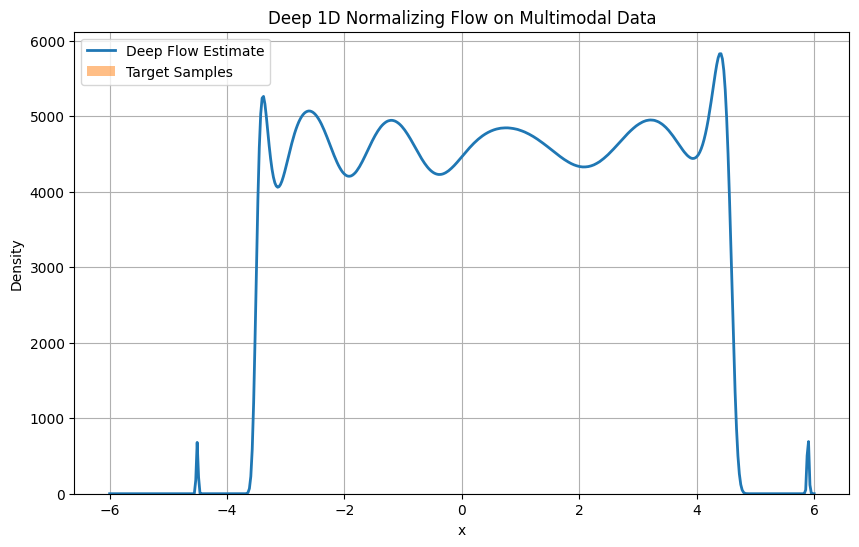

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ----- Device selection -----
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

# ----- Generate multimodal data -----
samples = np.concatenate([
    np.random.normal(-2, 0.5, size=5000),
    np.random.normal(2, 0.5, size=5000)
])
x_train = torch.tensor(samples, dtype=torch.float32).unsqueeze(1).to(device)

# ----- Affine Coupling Layer -----
class AffineCoupling(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.s = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.t = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        s = self.s(x)
        t = self.t(x)
        z = x * torch.exp(s) + t
        log_det_jacobian = s
        return z, log_det_jacobian

    def inverse(self, z):
        s = self.s(z)
        t = self.t(z)
        x = (z - t) * torch.exp(-s)
        log_det_jacobian = -s
        return x, log_det_jacobian

# ----- Deep Normalizing Flow -----
class DeepNormalizingFlow(nn.Module):
    def __init__(self, num_layers=4, hidden_dim=16):
        super().__init__()
        self.layers = nn.ModuleList([
            AffineCoupling(hidden_dim) for _ in range(num_layers)
        ])

    def forward(self, x):
        log_det_total = torch.zeros_like(x)
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_total += log_det
        return x, log_det_total

    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_base = -0.5 * z.pow(2) - 0.5 * torch.log(torch.tensor(2 * torch.pi, device=x.device))
        return (log_base + log_det).squeeze()

# ----- Training Setup -----
batch_size = 512
loader = DataLoader(TensorDataset(x_train), batch_size=batch_size, shuffle=True)

model = DeepNormalizingFlow(num_layers=4, hidden_dim=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----- Training Loop -----
for epoch in range(1000):
    for (batch,) in loader:
        loss = -model.log_prob(batch).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ----- Evaluation -----
x_eval = torch.linspace(-6, 6, 500).unsqueeze(1).to(device)
with torch.no_grad():
    log_pdf = model.log_prob(x_eval)
    pdf = torch.exp(log_pdf)

plt.figure(figsize=(10, 6))
plt.plot(x_eval.cpu().numpy(), pdf.cpu().numpy(), label="Deep Flow Estimate", linewidth=2)
plt.hist(samples, bins=50, density=True, alpha=0.5, label="Target Samples")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.title("Deep 1D Normalizing Flow on Multimodal Data")
plt.grid(True)
plt.show()


KDE vs Normalisation flow

Epoch 0: Loss = 2.5749
Epoch 100: Loss = 2.2593
Epoch 200: Loss = 2.1988
Epoch 300: Loss = 2.3534
Epoch 400: Loss = 2.1534
Epoch 500: Loss = 2.3043
Epoch 600: Loss = 2.2649
Epoch 700: Loss = 2.4392
Epoch 800: Loss = 2.5039
Epoch 900: Loss = 2.3080


/var/folders/1j/0q6grdh110z1c008s2nrczkm0000gn/T/ipykernel_79135/2663966998.py:74: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  true_pdf /= np.trapz(true_pdf, x_plot_np)  # Normalize manually


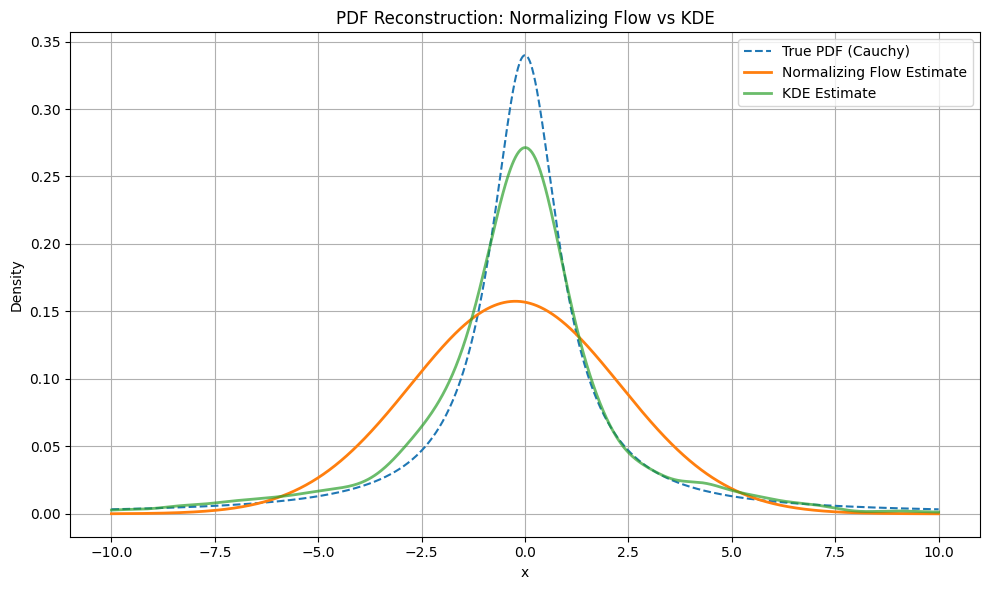

In [ ]:
# pdf_reconstruction_flow_vs_kde.py

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from nflows.flows import Flow
from nflows.transforms import CompositeTransform, MaskedAffineAutoregressiveTransform
from nflows.distributions import StandardNormal

# ---------- STEP 1: Simulate Markov Chain Samples ----------
def target_pdf(x):
    return 1 / (1 + x**2)  # Unnormalized Cauchy-like

def metropolis_sampler(f, N, x0=0.0, step_size=1.0):
    samples = [x0]
    x = x0
    for _ in range(N):
        x_new = x + step_size * np.random.randn()
        alpha = min(1, f(x_new) / f(x))
        if np.random.rand() < alpha:
            x = x_new
        samples.append(x)
    return np.array(samples)

# Generate MCMC samples
np.random.seed(0)
samples_np = metropolis_sampler(target_pdf, N=5000, step_size=1.0)
samples = torch.tensor(samples_np, dtype=torch.float32).unsqueeze(1)  # [N, 1]

# ---------- STEP 2: Build Normalizing Flow ----------
base_dist = StandardNormal(shape=[1])

transform = CompositeTransform([
    MaskedAffineAutoregressiveTransform(features=1, hidden_features=32),
    MaskedAffineAutoregressiveTransform(features=1, hidden_features=32),
    MaskedAffineAutoregressiveTransform(features=1, hidden_features=32),
])

flow = Flow(transform, base_dist)3

# ---------- STEP 3: Train the Flow ----------
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
epochs = 1000
batch_size = 256

for epoch in range(epochs):
    idx = torch.randint(0, samples.shape[0], (batch_size,))
    batch = samples[idx]
    log_probs = flow.log_prob(batch)
    loss = -log_probs.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# ---------- STEP 4: Evaluate PDF via Normalizing Flow ----------
x_plot = torch.linspace(-10, 10, 1000).unsqueeze(1)
with torch.no_grad():
    log_probs = flow.log_prob(x_plot).numpy()
pdf_flow = np.exp(log_probs)



# ---------- STEP 6: True Normalized PDF for Comparison ----------
true_pdf = target_pdf(x_plot_np)
true_pdf /= np.trapz(true_pdf, x_plot_np)  # Normalize manually

# ---------- STEP 7: Plot Results ----------
plt.figure(figsize=(10, 6))
plt.plot(x_plot_np, true_pdf, label="True PDF (Cauchy)", linestyle="--")
plt.plot(x_plot_np, pdf_flow, label="Normalizing Flow Estimate", linewidth=2)
plt.xlabel("x")
plt.ylabel("Density")
plt.title("PDF Reconstruction: Normalizing Flow")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
